In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date


('2017-08-23',)

In [10]:
measur_tabel = session.query(Measurement).order_by(Measurement.date.desc()).first()
measur_tabel.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1eb322f7590>,
 'station': 'USC00519397',
 'id': 2724,
 'prcp': 0.0,
 'date': '2017-08-23',
 'tobs': 81.0}

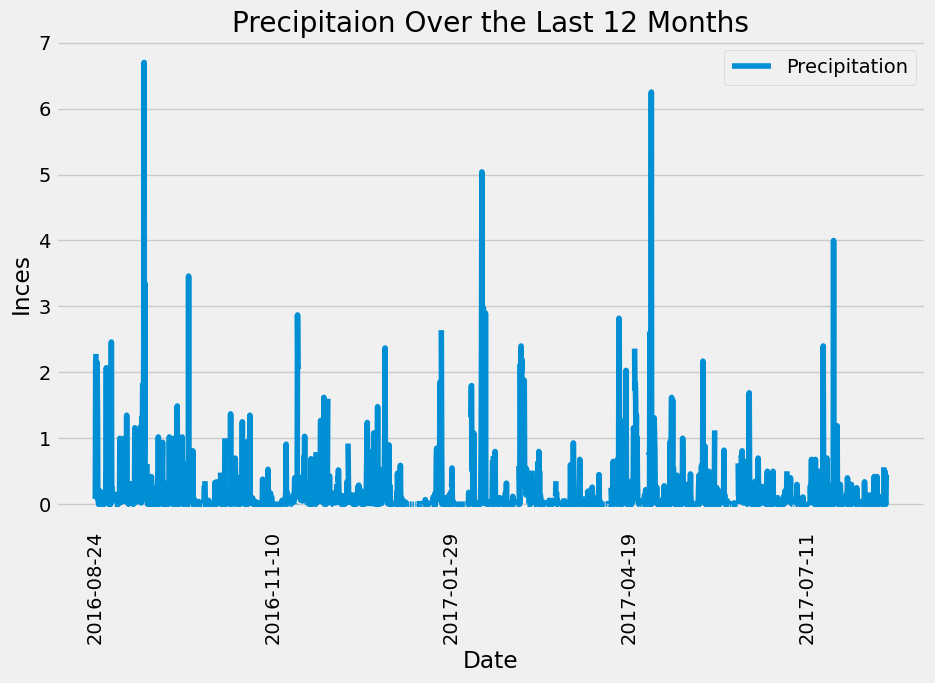

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# 2. Calculate the date 12 months ago from the most recent date.
most_recent_date_dt = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date_dt - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index('Date', inplace=True)
ax = precipitation_df.plot(figsize=(10,6), rot=90, legend=True)

# Customize grid lines: only show x-axis grid lines
ax.yaxis.grid(True)  # Disable y-axis grid lines
ax.xaxis.grid(False)   # Enable x-axis grid lines

plt.ylabel('Inces')
plt.xlabel('Date')
plt.title('Precipitaion Over the Last 12 Months')
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['Precipitation'].describe()
print(precipitation_summary)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total # of stations: {total_stations}")

Total # of stations: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                   .group_by(Measurement.station)
                   .order_by(func.count(Measurement.station).desc())
                   .all())
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0] # Since the order was descending, it must be the first result in the list

temperature_status = (session.query(func.min(Measurement.tobs),
                                    func.max(Measurement.tobs),
                                    func.avg(Measurement.tobs))
                                    .filter(Measurement.station  == most_active_station)
                                    .all())

lowest_temp, highest_temp, avg_temp = temperature_status[0]
print(f"Lowest: {lowest_temp}°F, Highest {highest_temp}°F, Average {avg_temp:.2f}°F")

Lowest: 54.0°F, Highest 85.0°F, Average 71.66°F


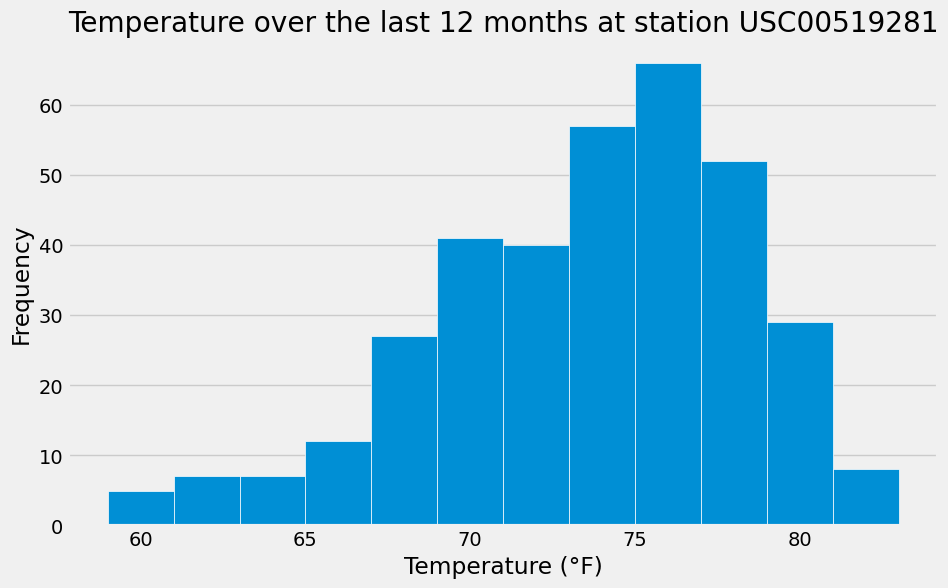

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (session.query(Measurement.tobs)
                    .filter(Measurement.station == most_active_station)
                    .filter(Measurement.date >= one_year_ago)
                    .order_by(Measurement.date)
                    .all())

# Converting the query to a list of temperatures
temperature_data_list = [temp[0] for temp in temperature_data]

# Plotting the results as histogram

plt.figure(figsize=(10,6))
plt.hist(temperature_data_list, bins=12, edgecolor='white')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f"Temperature over the last 12 months at station {most_active_station}")
plt.grid(axis='x')
plt.show()

# Close Session

In [27]:
# Close Session
session.close()